In [1]:
#EPieters HW5
#Question 1

In [2]:
import numpy as np
import matplotlib.pyplot as mpl
import glob
from simple_read_ligo import read_file, read_template
import json
from scipy.signal.windows import tukey #for windowing
from scipy.signal import savgol_filter #for smoothing

data_dir = 'LOSC_Event_tutorial/'

In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplo

## STILL TO DO

DEAL WITH PEAKS

do for all events

c)combined events

d) all of it

e)

f) add derivation

In [3]:
#WINDOWING: use kaiser window
#add an extended flat region at the top of the kaiser window
#default is an eigth of the window
def flattop_kaiser(m, beta, flat=1/8, DEBUG=False):
    m_win = int(m*(1-flat))
    m_win += int(m_win%2) #want an even number
    
    win = np.kaiser(m_win, beta)
    pad = np.ones(m-m_win)
    win_full= np.insert(win, int(m_win/2), pad)
    
    if DEBUG:
        mpl.figure()
        mpl.plot(win)
        mpl.plot(win_full)
        mpl.show()
    
    return win_full


#plot the FT of the data with different methods:
#without window, with kaiser window, with flat kaiser window
#returns data with flat kaiser window and with kaiser window
def examine_window_methods(data, beta, flat=1/8, DEBUG=False):
    m = len(data)
    win_kaiser = np.kaiser(m, beta)
    win_flatkaiser = flattop_kaiser(m, beta, flat)
    
    data_kaiser = data*win_kaiser
    data_flatkaiser = data*win_flatkaiser
    
    fft_data = np.fft.rfft(data)
    fft_data_kaiser = np.fft.rfft(data_kaiser)
    fft_data_flatkaiser = np.fft.rfft(data_flatkaiser)

    mpl.figure()
    mpl.plot(win_kaiser)
    mpl.plot(win_flatkaiser)
    mpl.title('Windows')
    mpl.legend(['kaiser', 'kaiser with flat top'])
    mpl.show()
    
    mpl.figure()
    mpl.loglog(np.abs(fft_data))
    mpl.loglog(np.abs(fft_data_kaiser))
    mpl.loglog(np.abs(fft_data_flatkaiser))
    mpl.title('FFT of windowed data')
    mpl.legend(['No window', 'kaiser', 'kaiser with flat top'])
    mpl.show()
    
    if DEBUG:
            mpl.figure()
            mpl.loglog(np.abs(fft_data_kaiser))
            mpl.title('FFT of kaiser windowed data')
            mpl.show()
            
            mpl.figure()
            mpl.loglog(np.abs(fft_data_flatkaiser))
            mpl.title('FFT of flat kaiser windowed data')
            mpl.show()
    
    return fft_data_flatkaiser, fft_data_kaiser


#create boxcar smooth via convolution
#have option to take maximum
def boxcar_smooth(data, m, take_max=True, DEBUG=False):
    box = np.zeros(len(data))
    #make symmetrix boxcar
    box[:m] = 1
    box[-m:] = 1
    box = box/sum(box) #normalize
    print('sum of  box should now be 1 ', sum(box))

    if DEBUG:
        mpl.figure()
        mpl.plot(box)
        mpl.title('box for boxcar smooth')
        mpl.show()

    #convolve the boxcar with the data
    smooth_data = np.fft.irfft( np.fft.rfft(data) * np.fft.rfft(box) , len(data))

    if DEBUG:
        print('is total power convserved? these should be the same ')
        print(np.mean(data), np.mean(smooth_data))

    if take_max:
        max_smooth_data = np.maximum(data, smooth_data)

        print(np.mean(max_smooth_data))

        if DEBUG:
            mpl.figure()
            mpl.loglog(np.abs(data))
            mpl.loglog(np.abs(smooth_data))
#             mpl.loglog(np.abs(max_smooth_data))
            mpl.title('max data')
#             mpl.legend(['ogirinal', 'smoothed', 'max'])
            mpl.show()

        return max_smooth_data

    return smooth_data


#function returns template based on current file name
def get_template(fname, DEBUG=False):
    with open(data_dir + 'BBH_events_v3.json') as json_file: 
        template_dict = json.load(json_file)
    for ii in template_dict:
        
        if data_dir + template_dict[ii]['fn_H1'] == fname:
            tname = template_dict[ii]['name'] #the name of the template
            tname_full = data_dir + tname + '_4_template.hdf5'
            th, tl = read_template(tname_full) #read in template file
            
            if DEBUG:
                print('for file ', fname, ' reading template ', tname_full)
                
            return th 
        
        if data_dir + template_dict[ii]['fn_L1'] == fname:
            tname = template_dict[ii]['name'] #the name of the template
            tname_full = data_dir + tname + '_4_template.hdf5'
            th, tl = read_template(tname_full) #read in template file
            
            if DEBUG:
                print('for file ', fname, ' reading template ', tname_full)
                
            return tl
        
    print('ERROR: template not found for file ', fname)
    return 0


def search_data(template, data, Nft=1):
    return np.fft.irfft( np.conj(np.fft.rfft(template)) * (np.fft.rfft(data)/Nft), len(data))

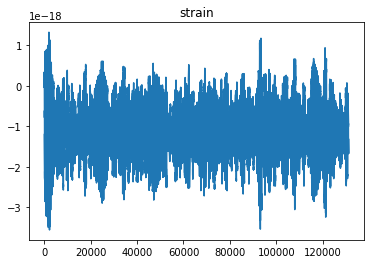

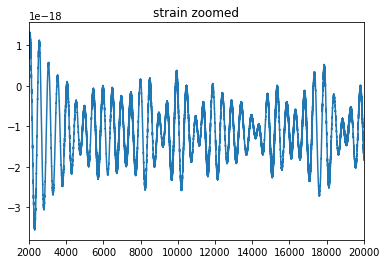

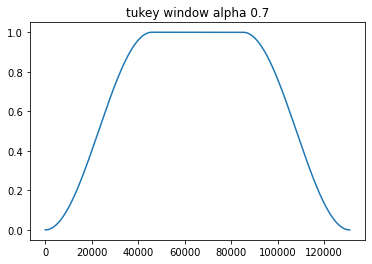

check that power is conserved
2.4244132728985854e-31 3.726975522354704e-31 2.046926286869725e-31


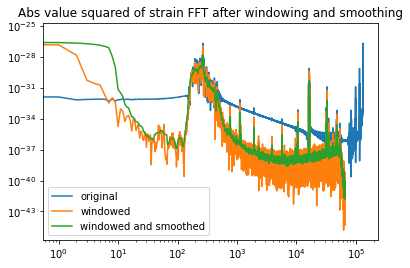

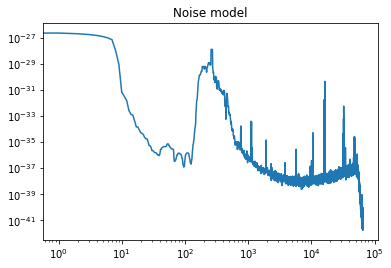

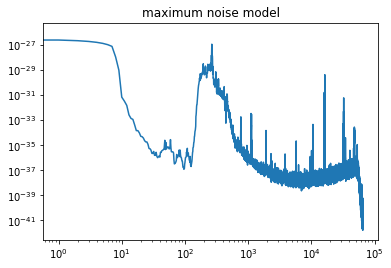

In [13]:
#PART A: come up with a noise model for Livingston and Hanford seperately

### READ IN DATA ###
livingston_files = glob.glob(data_dir + "L-*.hdf5")
hanford_files = glob.glob(data_dir + "H-*.hdf5")
# print(livingston_files)
# print(hanford_files)

fname = livingston_files[1]

#select a file
strain, dt, utc = read_file(fname)

#examine data
mpl.figure()
mpl.plot(strain)
mpl.title('strain')
mpl.show()

mpl.figure()
mpl.plot(strain)
mpl.title('strain zoomed')
mpl.xlim([2000, 20000])
mpl.show()


### WINDOWING AND SMOOTHING ###
#get different windowing methods
USE_KAISER = False
USE_TUKEY = True
USE_COS = False

#get different smoothing methods
USE_BOXCAR = False
USE_SAVGOL = True

if USE_KAISER: #BAD DON'T USE THIS INTRODUCES SPURIOUS CORRELATION IN CENTER WTF WHY HOW
    #BECAUSE IT DOESN'T GO TO ZERO AT THE EDGES THATS WHY
    #kaiser filter is tried due to the adjustability, can be similar to hanning, hamming, blackman filter
    # simply by adjusting beta
    #also to extend flat period in middle to avoid diminishing important signals too much
    #compares kaiser window with and without flat period. with flat period is chosen.
    beta = 5
    flat = 0.4
    fft_data_flatkaiser, fft_data_kaiser = examine_window_methods(strain, beta, flat, DEBUG=False)

    if True:
        win = flattop_kaiser(len(strain), beta, flat) # will need this window later
        fft_data_win = fft_data_flatkaiser
    else:
        win = np.kaiser(len(strain), beta)
        fft_data_win = fft_data_kaiser
    print(win)
        
    
if USE_TUKEY:
    # TUKEY window
    alpha = 0.5
    win = tukey(len(strain), alpha) #use scipy's tukey window
    fft_data_win = np.fft.rfft(win*strain)

    mpl.figure()
    mpl.plot(win)
    mpl.title('tukey window alpha ' + repr(alpha))
    mpl.show()
    
if USE_COS:
    theta = np.linspace(-np.pi, np.pi, len(strain))
    win = 0.5 + 0.5*np.cos(theta)
    fft_data_win = np.fft.rfft(win*strain)

#different kinds of smoothing
if USE_BOXCAR:
    #noise matrix take as windowed data squared: now SMOOTH it.
    boxcar_half_width = 5
    Nft = boxcar_smooth(np.abs(fft_data_win)**2, boxcar_half_width, take_max = False, DEBUG=False)
    print(max(np.imag(Nft)))
    
if USE_SAVGOL:
    win_len = 15
    polyorder = 1
    # scipy.signal.savgol_filter(x, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
    Nft = savgol_filter(np.abs(fft_data_win)**2, win_len, polyorder)
    
Nft_max = np.maximum(Nft, np.abs(fft_data_win)**2)
    
print('check that power is conserved')
print(np.mean(Nft), np.mean(Nft_max), np.mean(np.abs(fft_data_win)**2))


#examine effects on smoothing in frequency domain
mpl.figure()
mpl.loglog(np.abs(np.fft.fft(strain)**2))
mpl.loglog(np.abs(fft_data_win)**2)
mpl.loglog(Nft)
mpl.title('Abs value squared of strain FFT after windowing and smoothing')
mpl.legend(['original', 'windowed', 'windowed and smoothed'])
mpl.show()

mpl.figure()
mpl.loglog(Nft)
mpl.title('Noise model')
mpl.show()

mpl.figure()
mpl.loglog(Nft_max)
mpl.title('maximum noise model')
mpl.show()

for file  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5  reading template  LOSC_Event_tutorial/GW151226_4_template.hdf5


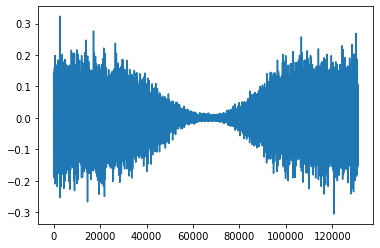

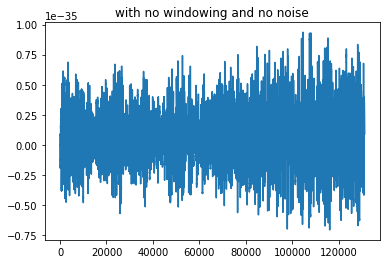

In [14]:
#PART B

#get the appropriate template for this data file
template = get_template(fname, DEBUG=True)

#window the template and the data
template_win = template*win
strain_win = strain*win

#perform a correlation taking into account the windowed, smoothed noise in fourier space
search = search_data(template_win, strain_win, Nft)

#what would the search have looked like with no noise and no window
search_nonoise = search_data(template, strain)

mpl.figure()
mpl.plot(search)
mpl.show()

mpl.figure()
mpl.plot(search_nonoise)
mpl.title('with no windowing and no noise')
mpl.show()

0.32320790626563756
2663
0.06639708363140365


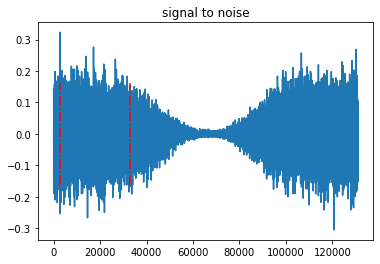

signal to noise ratio is 4.867802749589002


In [15]:
#PART C: use other formula

#TODO: how to get SNR for COMBINED events?? multiply.....??

def event_SNR_scatter(data, DEBUG=False):
    sig = np.max(np.abs(data))
    idx_max = int(np.where(np.abs(data)==np.max(np.abs(data)))[0])
    idx_max +=10 #shift it off the maximum by 10 to avoid including maximum
    num = int(30000)
#     idx_noise = range(idx_max, idx_max+num)
    noise = np.std(data[idx_max:(idx_max+num)])
    
    if DEBUG:
        print(sig)
        print(idx_max)
        print(noise)
        
        mpl.figure()
        mpl.plot(data)
        mpl.plot([idx_max, idx_max], [-sig/2, sig/2], 'r-.')
        mpl.plot([idx_max+num, idx_max+num], [-sig/2, sig/2], 'r-.')
        mpl.title('signal to noise')
        mpl.show()
    
    return sig/noise
    
SNR = event_SNR_scatter(search, DEBUG=True)
print('signal to noise ratio is', SNR)

In [7]:
#PART D:

#noise / standard deviation is the usual sqr(inv(AT N-1 A))
#signal to noise ratio is the m/sigma, the cross correlation divided by the error

def model_SNR(template, data, N):
    print('template shape ', template.shape)
    print('N shape ', N.shape)
    print('double N shape ', N.shape[0]*2)
    print('data shape ', data.shape)
    
    sigma = 1/np.sqrt(np.abs(sum(template / N * template)) )
    m = np.abs(sum(template / N * data))
    
    print('m is ', m)
    print('sigma is ', sigma)
    
    SNR = m/sigma
    print('SNR is ', SNR)
    
    return SNR
    
    
#     sigma = 1/np.sqrt
#     sigma = 1/np.sqrt(template.T/N*template)
#     print(sigma)


N = np.fft.irfft(Nft, len(template))
print(N.shape)
model_SNR(template, strain, N)

def recover_N(Nft, m):
#     Nft_diag = np.eye(len(Nft), dtype=np.single)*np.single(Nft)
    print(Nft_diag.shape)
    print(Nft)

# recover_N(Nft, len(template))


(131072,)
template shape  (131072,)
N shape  (131072,)
double N shape  262144
data shape  (131072,)
m is  0.1189703711308338
sigma is  12.184717167001322
SNR is  0.009763900917866983


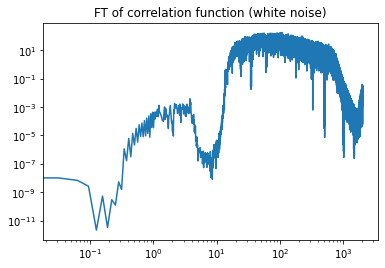

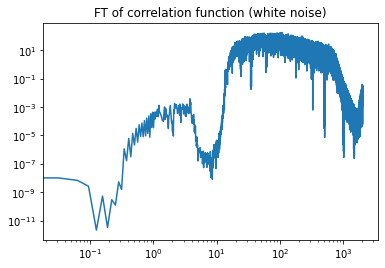

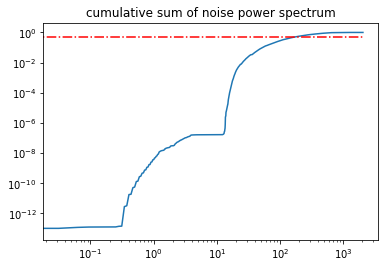

5490
closest idx, freq is :  5490 171.5625


In [8]:
#PART E:
#look at power spectrum in prewhiteened space. N-1/2*A, then FT.

# def half_weight_freq(template, data, Nft=1):
    
#     return np.fft.irfft( np.conj(np.fft.rfft(template)) * (np.fft.rfft(data)/Nft), len(data))

template_win_fft = np.fft.rfft(template_win)
strain_win_fft = np.fft.rfft(strain_win)

freqs = np.fft.rfftfreq(len(strain), dt)


#noise power spectrum is FT of correlation function
#sooo... basically... start correlation, leave in frequency space
corr_fft = np.conj(template_win_fft/(Nft**(1/2))) * (strain_win_fft/(Nft**(1/2)))
corr_fft_csum = np.cumsum( np.abs(corr_fft) / np.sum(np.abs(corr_fft))) #normalize it

mpl.figure()
mpl.loglog(freqs, np.abs(corr_fft))
mpl.title('FT of correlation function (white noise)')
mpl.show()

mpl.figure()
mpl.loglog(freqs, np.abs(corr_fft))
mpl.title('FT of correlation function (white noise)')
mpl.show()

mpl.figure()
mpl.loglog(freqs, corr_fft_csum)
mpl.loglog([min(freqs), max(freqs)], [0.5, 0.5], 'r-.')
mpl.title('cumulative sum of noise power spectrum')
mpl.show()

idx_half = np.argmin(np.abs(corr_fft_csum - 0.5))
print(idx_half)
print('closest idx, freq is : ', idx_half, freqs[idx_half])


# mpl.figure()
# mpl.loglog(np.abs(template_win_fft))
# # mpl.loglog(np.abs(template_win_fft)/np.sqrt(Nft))
# mpl.title('windowed  template fft')
# mpl.show()

# mpl.figure()
# mpl.loglog(np.abs(strain_win_fft))
# # mpl.loglog(np.abs(strain_win_fft)/np.sqrt(Nft))
# mpl.title('windowed strain fft')
# mpl.show()


# mpl.figure()
# # mpl.loglog(np.abs(template_win_fft))
# mpl.loglog(np.abs(template_win_fft)/np.sqrt(Nft))
# mpl.title('windowed template fft / N1/2')
# mpl.show()

# mpl.figure()
# # mpl.loglog(np.abs(strain_win_fft))
# mpl.loglog(np.abs(strain_win_fft)/np.sqrt(Nft))
# mpl.title('windowed strain fft / N1/2')
# mpl.show()



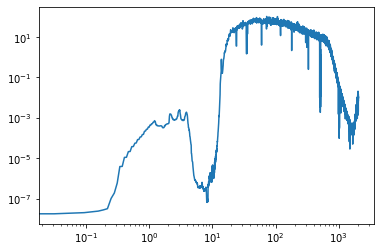

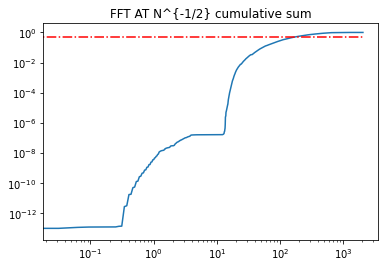

5477
closest idx, freq is :  5477 171.15625


In [9]:
#WAIT WAIT WAIT - from the TEMPLATE and the NOISE MODEL.
# so basically that's looking at the AtN1/2 gives you your WHITE NOISE TEMPLATE right?
#WHITE NOISE SOMETHING ABOUT GAUSSIANS
wn_template = template_win_fft / (Nft**(1/2))

mpl.figure()
mpl.loglog(freqs, np.abs(wn_template))
mpl.show()

wn_template_csum = np.cumsum( np.abs(wn_template) / np.sum(np.abs(wn_template))) #normalize it

mpl.figure()
mpl.loglog(freqs, corr_fft_csum)
mpl.loglog([min(freqs), max(freqs)], [0.5, 0.5], 'r-.')
mpl.title('FFT AT N^{-1/2} cumulative sum')
mpl.show()

idx_half = np.argmin(np.abs(wn_template_csum - 0.5))
print(idx_half)
print('closest idx, freq is : ', idx_half, freqs[idx_half])


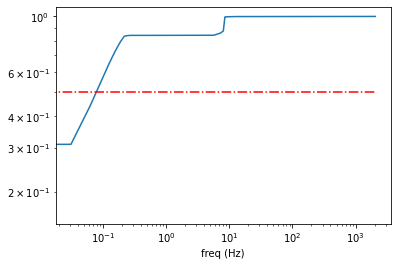

3
closest idx, freq is :  3 0.09375


In [10]:
#PART E CHEATER WAY
#cheater way - check when weights are cumulatively 1/2
freqs = np.fft.rfftfreq(len(strain), dt)
Nft_norm_csum = np.cumsum(Nft/sum(Nft))

mpl.figure()
mpl.loglog(freqs, Nft_norm_csum)
# mpl.loglog(Nft_norm_csum)
mpl.loglog([min(freqs), max(freqs)], [0.5, 0.5], 'r-.')
mpl.xlabel('freq (Hz)')
mpl.show()

idx_half = np.argmin(np.abs(Nft_norm_csum - 0.5))
print(idx_half)
print('closest idx, freq is : ', idx_half, freqs[idx_half])

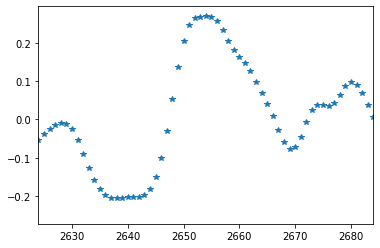

0.000244140625


In [11]:
# PART F
#time difference, gives path length difference on sky, gives a ring of where it's coming from.
# how WELL can we LOCALIZE it. look closer at correlation

def localize_event(data):
    
    idx_max = int(np.where(np.abs(data)==np.max(np.abs(data)))[0])

    zoom = 30
    mpl.figure()
    mpl.plot(data, '*')
    mpl.xlim([-zoom + idx_max, zoom + idx_max])
    mpl.show()

localize_event(search)
print(dt)
#can generally localize to within 2 dt. two timesteps.

In [12]:
dtheta = 1/2 * dt * (3*10**8) / 5000
print('average errors about ', dtheta)

dtheta_rad = dtheta * np.pi/180
print(dtheta_rad)

average errors about  7.32421875
0.12783173232380343
